# **Question 1. (70 marks)**
This question is designed to help you understand the working of a decision tree (DT). You will find a
dataset, [here](https://drive.google.com/file/d/1tqF3E3NWn6-tNtNWufcZzX6t0leOqDMs/view), containing information used to classify penguins into 3 species. \
 \
This question is designed to help you understand the working of a decision tree (DT). You will find a
dataset, here, containing information used to classify penguins into 3 species.
You need to implement a classification decision tree (DT) from scratch [you are not permitted to use
any 3rd-party library’s function for the classifier e.g. scikit. You may, however, use built-in functions for
auxiliary tasks like train/test split, etc.].
 * Odd roll numbers ( B20CS033 ) - Gini index 


1. Perform pre-processing and visualization of the dataset. Perform categorical encoding
wherever applicable and split the data into train and test sets - [7 marks].

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection

Visualising the plot, we can see that Torgersen island has only Adelie species as habitants. This could lead to 0 entropy for Adelie class while splitting via islands.



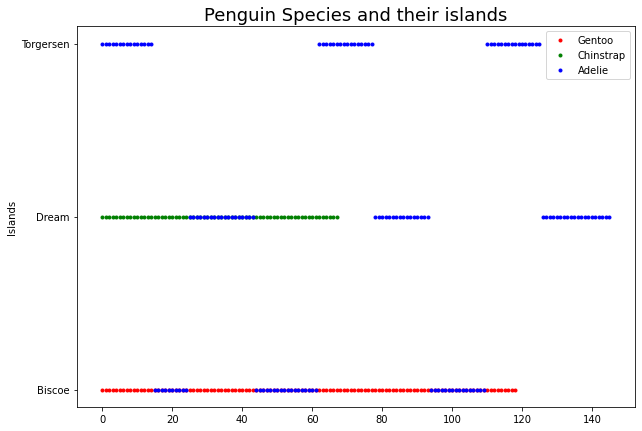


   island  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0       1            39.6           18.1              186.0       4450.0
1       1            36.5           18.0              182.0       3150.0
2       0            45.2           15.8              215.0       5300.0
3       0            45.5           13.9              210.0       4200.0
4       0            46.2           14.1              217.0       4375.0

  species
0  Adelie
1  Adelie
2  Gentoo
3  Gentoo
4  Gentoo


In [85]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Lab 2/penguins.csv')

df.dropna(inplace=True)
df.drop(['year','sex'],axis=1,inplace=True)

filter = df[df['species']=='Adelie']
filter1 = df[df['species']=='Gentoo']
filter2 = df[df['species']=='Chinstrap']
n=filter.shape[0]
n1=filter1.shape[0]
n2=filter2.shape[0]

print('Visualising the plot, we can see that Torgersen island has only Adelie species as habitants. This could lead to 0 entropy for Adelie class while splitting via islands.\n')
plt.figure(figsize=(10,7))
plt.title('Penguin Species and their islands',fontsize=18)
plt.plot(range(n1),filter1['island'],'ro',label='Gentoo',markersize=3)
plt.plot(range(n2),filter2['island'],'go',label='Chinstrap',markersize=3)
plt.plot(range(n),filter['island'],'bo',label='Adelie',markersize=3)      # plotted graphs for visualisation
plt.ylabel('Islands')
plt.legend()
plt.show()

l=[]                                
for i in df['island']:              # categorical encoding for islands
    if i=='Biscoe':                 
        l.append(0)                 # Biscoe    = 0          
    elif i=='Dream':                # Dream     = 1
        l.append(1)                 # Torgersen = 2
    else:
        l.append(2)
df['island']=l
del l

Y = pd.DataFrame(df['species'])
X = df.drop(['species'],axis=1)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=.25, random_state=41)

X_train.reset_index(drop=True,inplace=True)
Y_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
Y_test.reset_index(drop=True,inplace=True)

print()
print(X_train.head())
print()
print(Y_train.head())

2. Implement the cost function as per Gini index - [5 marks].

In [ ]:
def gini_index(data):
    all_classes = np.unique(data)
    gini = 0
    for class_ in all_classes:
        p_class = len(data[data == class_]) / len(data)
        gini += p_class**2
    return 1 - gini

3. In order for the decision tree to work successfully, continuous variables need to be converted
to categorical variables first. To do this, you need to implement a decision function that makes
this split. Let us call that cont_to_cat(). The details of the function are the following. \
[10 marks]:- \
 a) Assume that the continuous variables are independent of each other i.e. assuming 2
continuous variables A and B, the split of A does not in any way affect the split you will
perform in B. \
b) The continuous variables should only be split into 2 categories, and the optimal split is
one that divides the samples the best, based on the value of Gini index.

In [ ]:
def cont_to_cat(dataset):
    best_split = {}
    max_IG = -10

    for fi in range(np.shape(dataset)[1]-1):
        feature_values = dataset[:, fi]
        thresholds = np.unique(feature_values)

        for th in thresholds:
            dataset_left = np.array([x for x in dataset if x[fi]<=th])
            dataset_right = np.array([x for x in dataset if x[fi]>th])

            if len(dataset_left)>0 and len(dataset_right)>0:
                y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                left_w = len(left_y) / len(y)
                right_w = len(right_y) / len(y)

                curr_IG = gini_index(y) - (left_w*gini_index(left_y) + right_w*gini_index(right_y))

                if curr_IG>max_IG:
                    best_split["feature_index"] = fi
                    best_split["threshold"] = th
                    best_split["dataset_left"] = dataset_left
                    best_split["dataset_right"] = dataset_right
                    best_split["info_gain"] = curr_IG
                    max_IG = curr_IG
                    
    return best_split

4. After step 2, all the attributes would have categorical values, so now you can go ahead and
implement the training function. This would include implementing the following helper
functions: [25 marks] \
a. Get the attribute that leads to the best split \
b. Make that split \
c. Repeat these steps for the newly-created split 

5. The DT should also include the following properties in the train function \
a. There should be a max depth that should be defined i.e. a depth after which the tree shouldn’t be allowed to grow [5 marks] \
b. The algorithm should self-identify when there is no information gain being done, i.e. the
model has plateaued in it’s training and shouldn’t grow further. [5 marks]

In [ ]:
class Node():
    def __init__(self, left=None, right=None, feature_index=None, threshold=None, IG=None, value=None):
        self.left = left
        self.right = right      
        self.feature_index = feature_index
        self.threshold = threshold
        self.IG = IG
        self.value = value

def build_decision_tree(dataset, curr_depth=0):
    min_samples = 4
    max_depth = 3               # for max_depth = 4, we get overall accuracy of 97 %
    X = dataset[:,:-1]          # so max_depth = 3  performs better with an accuracy of 98 %
    Y = dataset[:,-1]        
    if np.shape(X)[0]>=min_samples and curr_depth<=max_depth:
        best_split = cont_to_cat(dataset)
        if best_split["info_gain"]>0:
            left_subtree = build_decision_tree(best_split["dataset_left"], curr_depth+1)
            right_subtree = build_decision_tree(best_split["dataset_right"], curr_depth+1)
            return Node(left_subtree, right_subtree, best_split["feature_index"], best_split["threshold"], best_split["info_gain"])
    
    leaf_value = max(list(Y), key=list(Y).count)
    return Node(value=leaf_value)

def train_model(X, Y):
    root = None
    X = np.array(X)
    Y = np.array(Y)
    np.reshape(Y,(-1,1))
    dataset = np.concatenate((X, Y), axis=1)
    root = build_decision_tree(dataset)
    return root

trained_model = train_model(X_train,Y_train)

6. Write a function which is responsible for classification (i.e. at test time). [10 marks]

In [ ]:
def classify(trained_model, X):
    X = np.array(X)
    preditions = []
    for x in X:
        pred = predict(x, trained_model)
        preditions.append(pred)
    return preditions

def predict(x, tree):
    if tree.value!=None: 
        return tree.value
    feature_val = x[tree.feature_index]
    if feature_val<=tree.threshold:
        return predict(x, tree.left)
    else:
        return predict(x, tree.right)

Y_predicted = np.array((classify(trained_model,X_test)))
Y_test = pd.DataFrame(Y_test)['species']
Y_test = np.array(Y_test)


7. Find out the accuracy you get on the test data (overall and class-wise). [3 marks]

In [ ]:
from sklearn.metrics import accuracy_score
print(f'Overall Accuracy for trained Model : {accuracy_score(Y_test, Y_predicted)*100:.2f} %')

conf_mat=np.zeros((3,3),dtype='i')

def encode(species):
    if species=='Gentoo':
        return 0
    if species=='Adelie':
        return 1
    return 2

def decode(n):
    if n==0:
        return 'Gentoo'
    if n==1:
        return 'Adelie'
    return 'Chinstrap'

for i in range(len(Y_test)):
    r = encode(Y_test[i])
    c = encode(Y_predicted[i])
    conf_mat[r][c]+=1

print('\nConfusion Matrix :')
print(conf_mat)

class_wise_counts = {}
predicted_class_counts = {}
for i in Y_test:
    if i not in class_wise_counts.keys():
        class_wise_counts[i]=1
    else:
        class_wise_counts[i]+=1

print('\nClass wise accuracy :\n')

for i in range(3):
    species = decode(i)
    sm=0
    for j in range(3):
        sm+=conf_mat[i][j]
    accuracy = conf_mat[i][i]/sm*100
    print(f'Class Accuracy for {species} : {accuracy:.2f} %')

Overall Accuracy for trained Model : 97.62 %

Confusion Matrix :
[[32  0  0]
 [ 0 33  1]
 [ 0  1 17]]

Class wise accuracy :

Class Accuracy for Gentoo : 100.00 %
Class Accuracy for Adelie : 97.06 %
Class Accuracy for Chinstrap : 94.44 %


***
# **Question 2. [30 marks]** 
This question involves performing regression using a decision tree. You are permitted to use the
sklearn library for this question. The dataset involves energy analysis, and this problem is centered
around understanding how machine learning is applied in the industry.
The dataset contains eight attributes (X1, ..., X8) (representative of different properties of buildings like
height, roof area, etc.) and one response (Y1) (the heating load for the building). The aim is to use the
eight features to predict Y1. (You are permitted to use 3rd-party libraries for this question).
The tasks for this question are the following :-

1. Preprocess the data. Split it using a 70:10:20 ratio, which represents training:validation:testing. - [5 marks]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import metrics

df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Lab 2/ENB2012_data.xlsx')
df.dropna(inplace=True)
scaler = preprocessing.MinMaxScaler()
x5 = scaler.fit_transform(pd.DataFrame(df['X5']))
df['X5']=x5

Y = df['Y1']
X = df.drop(['Y1'],axis=1)

X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X,Y,test_size=0.3,random_state=47)
X_val, X_test, Y_val, Y_test = model_selection.train_test_split(X_val,Y_val,test_size=0.6666)



2. Write a function to train the data using a regression decision tree. The function varies
hyper-parameters to find the tree that generalizes best (based on its performance on the
validation set). So, you need to train on the 70% training data and check performance on the
10% validation data. \
Properly explain the thought process behind which hyper-parameters you vary and the
expected effects in the report. Make plots of validation MSE to support your arguments. [20 marks] \
Note: Here we are evaluating the method involved in the generalization rather than the achieved
accuracy. Please refrain from using any inbuilt scikit library functions for hyper-parameterization
(eg:- grid search).


In [55]:
regressor_model = DecisionTreeRegressor()
regressor_model.fit(X_train,Y_train)
Y_predicted = regressor_model.predict(X_val)
MSE = metrics.mean_squared_error(Y_val, Y_predicted)

print(f'MSE before Hyper-Parameter Tuning : {MSE:.4f}')

parameters={'splitter':['best','random'],
            'max_depth' : range(1,11),
           'min_samples_leaf':range(1,11),
           'max_leaf_nodes':range(10,100,10) }

optimal_params = ['',0,0,0]

all_mses = {'splitter':[],
            'max_depth' : [],
           'min_samples_leaf':[],
           'max_leaf_nodes':[] }
tuned_mse = 1000

curr_tuning_mse = 1000
for spltr in parameters['splitter']:
    optimal_regressor_model = DecisionTreeRegressor(criterion='squared_error',splitter=spltr)
    optimal_regressor_model.fit(X_train,Y_train)
    Y_predicted_optimal = optimal_regressor_model.predict(X_val)
    mse = metrics.mean_squared_error(Y_val, Y_predicted_optimal)
    all_mses['splitter'].append(mse)
    if mse<curr_tuning_mse:
        curr_tuning_mse = mse
        optimal_params[0] = spltr
    if mse<tuned_mse:
        tuned_mse = mse

optimal_splitter = optimal_params[0]

curr_tuning_mse = 1000
for mln in parameters['max_leaf_nodes']:
    optimal_regressor_model = DecisionTreeRegressor(criterion='squared_error',splitter=optimal_splitter,max_leaf_nodes=mln)
    optimal_regressor_model.fit(X_train,Y_train)
    Y_predicted_optimal = optimal_regressor_model.predict(X_val)
    mse = metrics.mean_squared_error(Y_val, Y_predicted_optimal)
    all_mses['max_leaf_nodes'].append(mse)
    if mse<curr_tuning_mse:
        curr_tuning_mse = mse
        optimal_params[3] = mln
    if mse<tuned_mse:
        tuned_mse = mse

optimal_max_leaf_nodes = optimal_params[3]

curr_tuning_mse = 1000
for max_d in parameters['max_depth']:
    optimal_regressor_model = DecisionTreeRegressor(criterion='squared_error',splitter=optimal_splitter,max_leaf_nodes=optimal_max_leaf_nodes,max_depth=max_d)
    optimal_regressor_model.fit(X_train,Y_train)
    Y_predicted_optimal = optimal_regressor_model.predict(X_val)
    mse = metrics.mean_squared_error(Y_val, Y_predicted_optimal)
    all_mses['max_depth'].append(mse)
    if mse<curr_tuning_mse:
        curr_tuning_mse = mse
        optimal_params[1] = max_d
    if mse<tuned_mse:
        tuned_mse = mse

optimal_max_depth = optimal_params[1]

curr_tuning_mse = 1000
for msl in parameters['min_samples_leaf']:
    optimal_regressor_model = DecisionTreeRegressor(criterion='squared_error',splitter=optimal_splitter,max_leaf_nodes=optimal_max_leaf_nodes,max_depth=optimal_max_depth,min_samples_leaf=msl)
    optimal_regressor_model.fit(X_train,Y_train)
    Y_predicted_optimal = optimal_regressor_model.predict(X_val)
    mse = metrics.mean_squared_error(Y_val, Y_predicted_optimal)
    all_mses['min_samples_leaf'].append(mse)
    if mse<curr_tuning_mse:
        curr_tuning_mse = mse
        optimal_params[2] = msl
    if mse<tuned_mse:
        tuned_mse = mse

optimal_min_samples_leaf = optimal_params[2]

print(f'\noptimal_splitter : {optimal_splitter}')
print(f'optimal_max_leaf_nodes : {optimal_max_leaf_nodes}')
print(f'optimal_max_depth : {optimal_max_depth}')
print(f'optimal_min_samples_leaf : {optimal_min_samples_leaf}\n')

optimal_regressor_model = DecisionTreeRegressor(criterion='squared_error',splitter= optimal_splitter,max_leaf_nodes= optimal_max_leaf_nodes,max_depth= optimal_max_depth,min_samples_leaf= optimal_min_samples_leaf)
optimal_regressor_model.fit(X_train,Y_train)
Y_predicted_optimal = optimal_regressor_model.predict(X_val)
mse = metrics.mean_squared_error(Y_val, Y_predicted_optimal)

print(f'MSE after Hyper-Parameter Tuning : {tuned_mse:.4f}')


MSE before Hyper-Parameter Tuning : 0.2834

optimal_splitter : best
optimal_max_leaf_nodes : 80
optimal_max_depth : 9
optimal_min_samples_leaf : 1

MSE after Hyper-Parameter Tuning : 0.2427


optimal_max_depth : 9



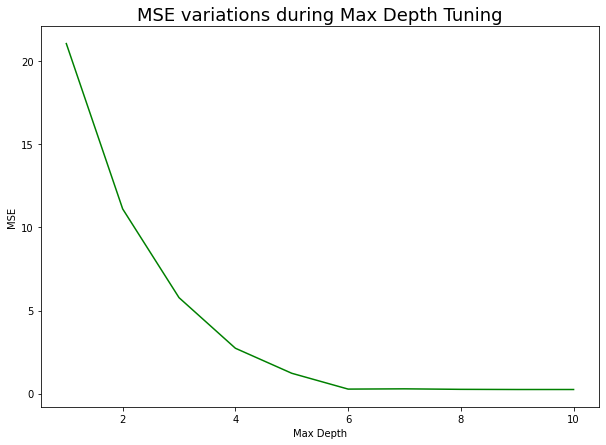

In [56]:
print(f'optimal_max_depth : {optimal_max_depth}\n')
plt.figure(figsize=(10,7))
plt.title('MSE variations during Max Depth Tuning',fontsize=18)
plt.plot(parameters['max_depth'],all_mses['max_depth'],'g',markersize=4)
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.show()

optimal_splitter : best



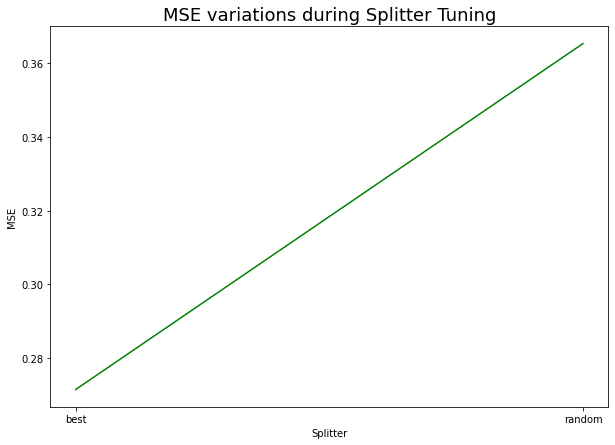

In [57]:
print(f'optimal_splitter : {optimal_splitter}\n')
plt.figure(figsize=(10,7))
plt.title('MSE variations during Splitter Tuning',fontsize=18)
plt.plot(parameters['splitter'],all_mses['splitter'],'g',markersize=4)
plt.xlabel('Splitter')
plt.ylabel('MSE')
plt.show()

optimal_max_leaf_nodes : 80



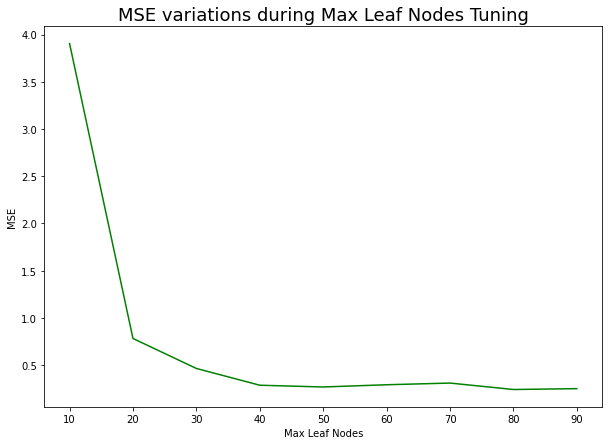

In [58]:
print(f'optimal_max_leaf_nodes : {optimal_max_leaf_nodes}\n')
plt.figure(figsize=(10,7))
plt.title('MSE variations during Max Leaf Nodes Tuning',fontsize=18)
plt.plot(parameters['max_leaf_nodes'],all_mses['max_leaf_nodes'],'g',markersize=4)
plt.xlabel('Max Leaf Nodes')
plt.ylabel('MSE')
plt.show()

optimal_min_samples_leaf : 1



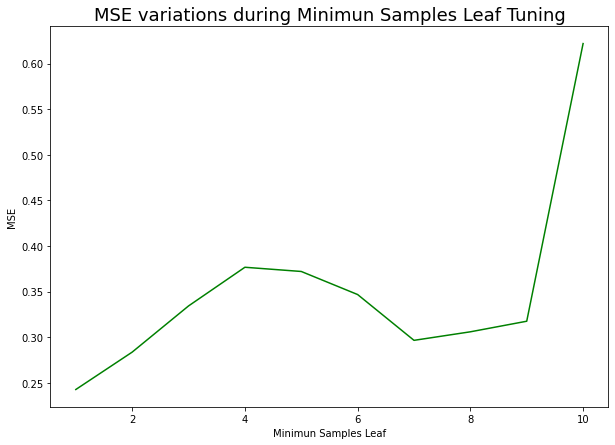

In [59]:
print(f'optimal_min_samples_leaf : {optimal_min_samples_leaf}\n')
plt.figure(figsize=(10,7))
plt.title('MSE variations during Minimun Samples Leaf Tuning',fontsize=18)
plt.plot(parameters['min_samples_leaf'],all_mses['min_samples_leaf'],'g',markersize=4)
plt.xlabel('Minimun Samples Leaf')
plt.ylabel('MSE')
plt.show()

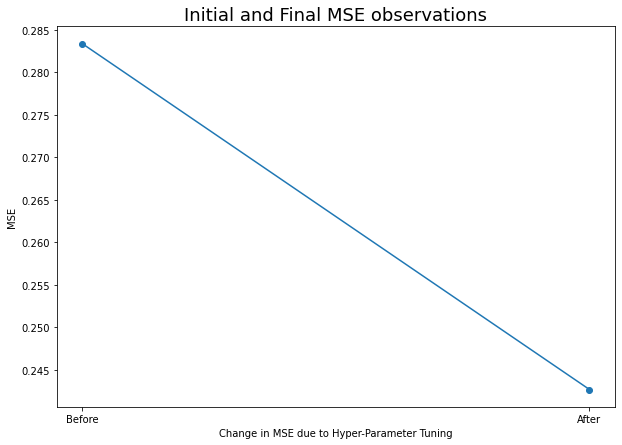

In [60]:
plt.figure(figsize=(10,7))
plt.title('Initial and Final MSE observations',fontsize=18)
plt.plot(['Before','After'],[MSE,tuned_mse],marker='o')
plt.xlabel('Change in MSE due to Hyper-Parameter Tuning')
plt.ylabel('MSE')
plt.show()


3. Perform 5-fold cross-validation using the optimal hyper-parameters decided in the previous
question. Finally, calculate the mean squared error between the predicted and the ground-truth
values in the test data for your best model. Also, plot the decision tree created [5 marks].

In [63]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

optimal_regressor_model = DecisionTreeRegressor(criterion='squared_error',splitter= optimal_splitter,max_leaf_nodes= optimal_max_leaf_nodes,max_depth= optimal_max_depth,min_samples_leaf= optimal_min_samples_leaf)
optimal_regressor_model.fit(X_train,Y_train)

scores = cross_val_score(optimal_regressor_model, X_train, Y_train,scoring='neg_mean_squared_error', cv=KFold(5,random_state=1,shuffle = True))
print('5-fold cross validation Mean Square Errors : ')
print(-scores)
avg_MSE = np.mean(-scores)
print(f'\nAverage MSE for 5-fold cross validation : {avg_MSE:.4f}')

Y_predicted = optimal_regressor_model.predict(X_test)
final_MSE = metrics.mean_squared_error(Y_test, Y_predicted)
print(f'\nFinal MSE for predictions on testing data : {final_MSE:.4f}\n')


5-fold cross validation Mean Square Errors : 
[0.40475494 0.32017093 0.40428392 0.29759929 0.48563558]

Average MSE for 5-fold cross validation : 0.3825

Final MSE for predictions on testing data : 0.2672



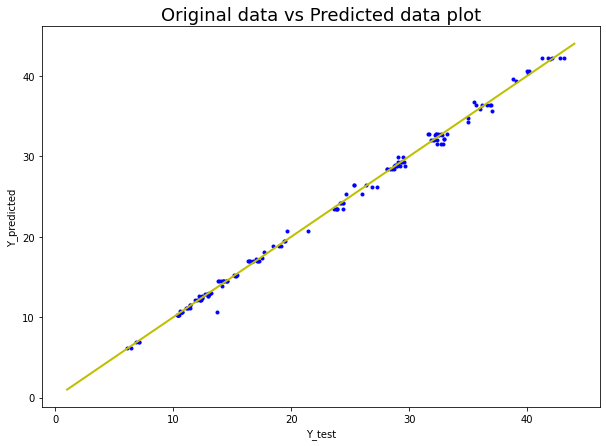

In [64]:
plt.figure(figsize=(10,7))
plt.title('Original data vs Predicted data plot',fontsize=18)
plt.plot(Y_test, Y_predicted,'bo',markersize=3)
plt.plot(range(1,45),range(1,45),'y',linewidth=2)
plt.xlabel('Y_test')
plt.ylabel('Y_predicted')
plt.show()

Decision Tree plot :



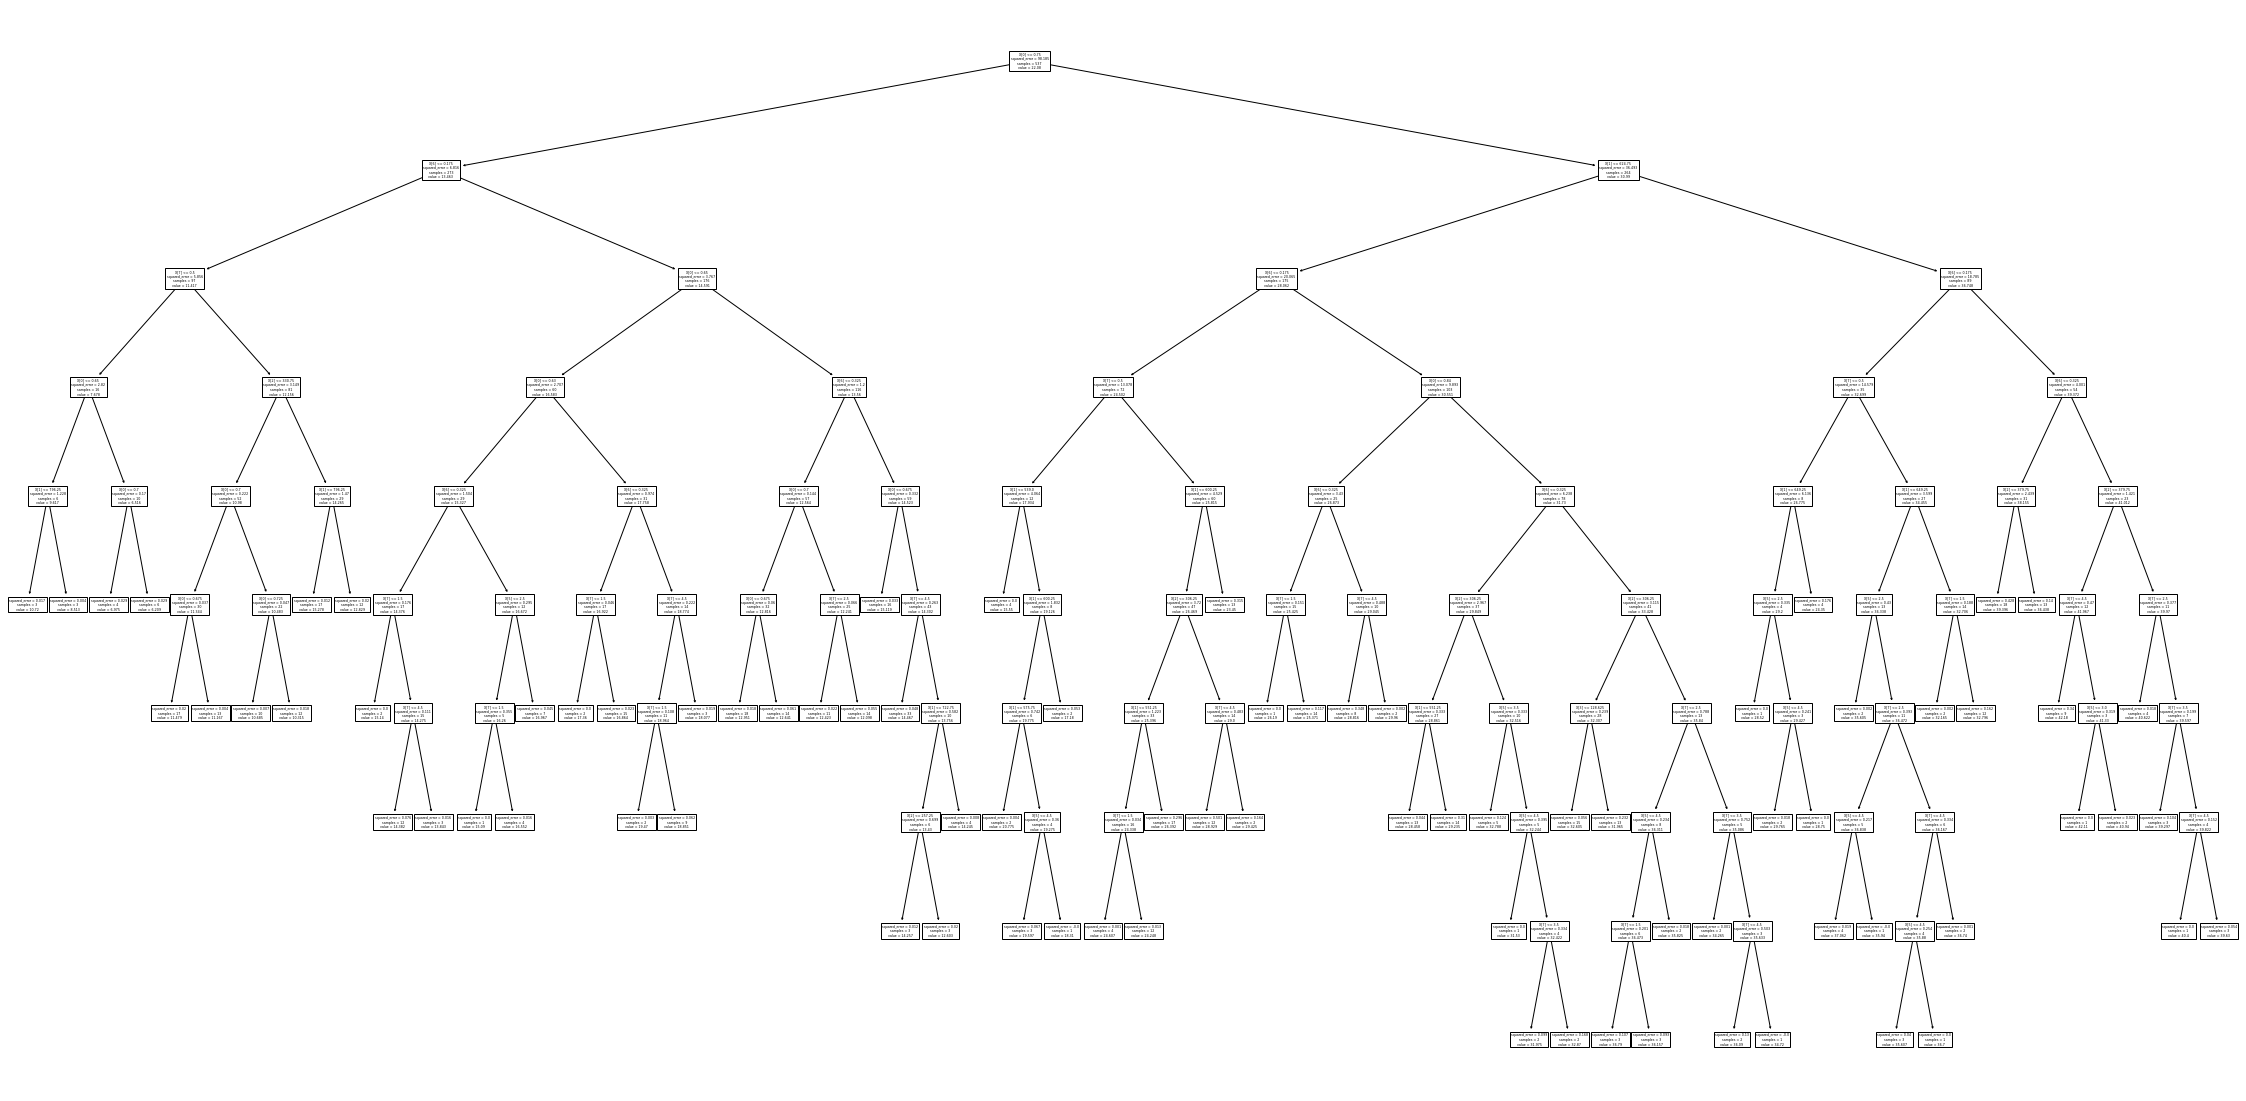

In [65]:
print('Decision Tree plot :\n')

plt.figure(figsize = (40,20))
plot_tree(optimal_regressor_model)
plt.show()